# 1. 데이터 로드

### 주요 import 할것들 미리 해두기 (나머지는 그때그때)

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime as dt
from datetime import timedelta as td

In [2]:
import utils

### 경로 등 global config 설정

In [3]:
RAW_ROOT = 'raw'
DATA_ROOT = 'data'

### 각종 데이터 불러오기

In [4]:
%%time
df_user_raw, df_item_raw, df_log_raw, df_sub_raw = utils.load_raw(RAW_ROOT)

CPU times: user 12.6 s, sys: 6.92 s, total: 19.5 s
Wall time: 18.3 s


In [5]:
%%time
df_item = pd.read_parquet(f'{DATA_ROOT}/df_item_preprocessed.pq')
df_log_all = pd.read_parquet(f'{DATA_ROOT}/df_log_preprocessed.pq')

CPU times: user 11.4 s, sys: 5.3 s, total: 16.7 s
Wall time: 15.3 s


### 중요!!! CV, LB 설정

즉, 두번 돌려야함

In [6]:
DNAME = 'LB'

In [7]:
%%time
df_log = utils.get_df_log_of(df_log_all, DNAME)
df_log = df_log[df_log['target'] != 'test']

CPU times: user 8.3 s, sys: 7.43 s, total: 15.7 s
Wall time: 15.3 s


In [8]:
del df_log_all

---

# 2. Sales Channel 관련

유저랑 똑같이 진행

In [9]:
df_channel_count = df_log['sales_channel_id'].value_counts()
df_channel_count

2    10780517
1     4240397
Name: sales_channel_id, dtype: int64

In [10]:
global_online_prob = df_channel_count.loc[2] / (df_channel_count.loc[2] + df_channel_count.loc[1])
global_online_prob

0.7177004674948542

In [11]:
%%time
ss_sc_online_count = df_log[df_log['sales_channel_id'] == 2].groupby('article_id').size()
ss_sc_offline_count = df_log[df_log['sales_channel_id'] == 1].groupby('article_id').size()

CPU times: user 2.93 s, sys: 683 ms, total: 3.61 s
Wall time: 3.53 s


In [12]:
df_item['online_prob'] = ss_sc_online_count / (ss_sc_online_count + ss_sc_offline_count)

In [13]:
del ss_sc_online_count
del ss_sc_offline_count

<AxesSubplot:ylabel='Frequency'>

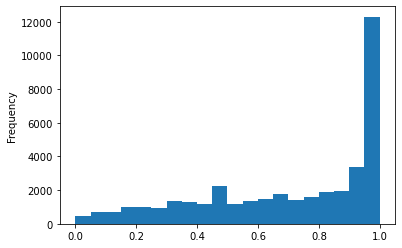

In [14]:
df_item[~df_item['online_prob'].isna()]['online_prob'].plot.hist(bins=20)

In [15]:
df_item['online_prob'].fillna(global_online_prob, inplace=True)

---

# 3. Price 관련

마찬가지로 분포부터 확인. 유저랑 너무 똑같나?

CPU times: user 1.48 s, sys: 437 ms, total: 1.92 s
Wall time: 1.92 s


<AxesSubplot:ylabel='Frequency'>

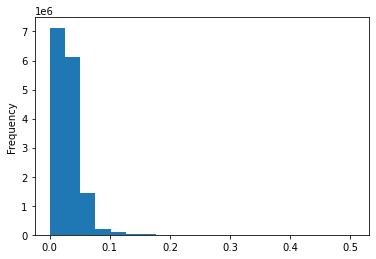

In [16]:
%%time
df_log['price'].plot.hist(bins=20)

In [17]:
%%time
df_item_of_avg_price = df_log.groupby('article_id')['price'].mean('price')
df_item_of_avg_price.name = 'avg_price'

CPU times: user 1.55 s, sys: 181 ms, total: 1.73 s
Wall time: 1.72 s


In [18]:
global_avg_price = df_log['price'].mean()
global_avg_price

0.028251888996179735

In [19]:
df_item = df_item.merge(df_item_of_avg_price, how='left', left_index=True, right_index=True)
df_item['avg_price'].fillna(global_avg_price, inplace=True)

<AxesSubplot:ylabel='Frequency'>

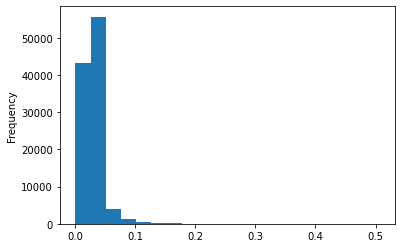

In [20]:
df_item['avg_price'].plot.hist(bins=20)

In [21]:
df_item.isna().sum()

product_code                  0
prod_name                     0
product_type_no               0
graphical_appearance_no       0
colour_group_code             0
perceived_colour_value_id     0
perceived_colour_master_id    0
department_no                 0
index_code                    0
index_group_no                0
section_no                    0
garment_group_no              0
detail_desc                   0
product_group_no              0
ipath                         0
online_prob                   0
avg_price                     0
dtype: int64

---

# 4. Season 관련

은근히 많은 일이 있었지만... 그냥 유저의 cohort, garment랑 똑같이 진행하는게 제일 나을듯 함.

뭔가 로그도 찍어보고 그래프도 그려보고 했는데ㅋㅋㅋ..

### 계절 맵핑

In [22]:
month2season = {
    1: 'winter',
    2: 'winter',
    3: 'spring',
    4: 'spring',
    5: 'spring',
    6: 'summer',
    7: 'summer',
    8: 'summer',
    9: 'fall',
    10: 'fall',
    11: 'fall',
    12: 'winter',
}

In [23]:
%%time
dts_to_season_map = {}
for dts in df_log['t_dat'].unique():
    month = int(dts.split('-')[1])
    season = month2season[month]
    dts_to_season_map[dts] = season

CPU times: user 724 ms, sys: 41.8 ms, total: 765 ms
Wall time: 762 ms


In [24]:
%%time
df_log['season'] = df_log['t_dat'].map(dts_to_season_map)

CPU times: user 819 ms, sys: 152 ms, total: 971 ms
Wall time: 968 ms


In [25]:
season_to_count_map = df_log['season'].value_counts().sort_values(ascending=False).to_dict()
season_to_count_map

{'summer': 4353201, 'spring': 3750449, 'fall': 3720736, 'winter': 3196528}

<AxesSubplot:ylabel='season'>

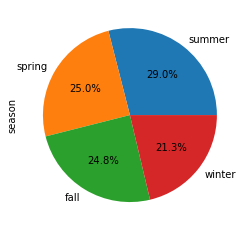

In [26]:
df_season_count = df_log['season'].value_counts()
df_season_count.plot(kind='pie', autopct='%1.1f%%')

In [27]:
df_season_dist = df_season_count.copy()
df_season_dist = df_season_dist / df_season_dist.sum()
df_season_dist

summer    0.289809
spring    0.249682
fall      0.247704
winter    0.212805
Name: season, dtype: float64

In [28]:
%%time
df_item_of_season_counts = df_log[['customer_id', 'article_id', 'season']].groupby(['article_id', 'season']).count().unstack()
df_item_of_season_counts.fillna(0, inplace=True)
df_item_of_season_counts.columns = [f'season_prob_{season}' for _, season in df_item_of_season_counts.columns.to_list()]

CPU times: user 5.71 s, sys: 1.5 s, total: 7.21 s
Wall time: 7.2 s


In [29]:
df_item_of_season_dist = df_item_of_season_counts.div(df_item_of_season_counts.sum(1), axis='index')
df_item = df_item.merge(df_item_of_season_dist, how='left', left_index=True, right_index=True)

In [30]:
del df_item_of_season_counts
del df_item_of_season_dist

In [31]:
for index in df_season_dist.index.to_list():
    df_item[f'season_prob_{index}'].fillna(df_season_dist.loc[index], inplace=True)

In [32]:
df_item.isna().sum()

product_code                  0
prod_name                     0
product_type_no               0
graphical_appearance_no       0
colour_group_code             0
perceived_colour_value_id     0
perceived_colour_master_id    0
department_no                 0
index_code                    0
index_group_no                0
section_no                    0
garment_group_no              0
detail_desc                   0
product_group_no              0
ipath                         0
online_prob                   0
avg_price                     0
season_prob_fall              0
season_prob_spring            0
season_prob_summer            0
season_prob_winter            0
dtype: int64

---

# 5. Transaction Count 관련

유저랑 똑같이 진행

In [33]:
%%time
ss_transaction_count = df_log.groupby('article_id').size()
ss_transaction_count.name = 'transaction_count'

CPU times: user 1.49 s, sys: 165 ms, total: 1.66 s
Wall time: 1.65 s


In [34]:
df_item = df_item.merge(ss_transaction_count, how='left', left_index=True, right_index=True)
df_item['transaction_count'].fillna(0, inplace=True)

In [35]:
del ss_transaction_count

CPU times: user 89.6 ms, sys: 799 µs, total: 90.4 ms
Wall time: 89.9 ms


<AxesSubplot:ylabel='Frequency'>

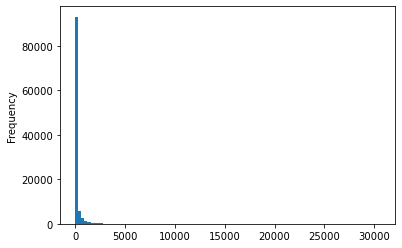

In [36]:
%%time
df_item['transaction_count'].plot.hist(bins=100)

In [37]:
print(f"total item: {len(df_item)}")
print(f"transaction count 50% percentile: {int(np.percentile(df_item['transaction_count'], 50))}")
print(f"transaction count 99% percentile: {int(np.percentile(df_item['transaction_count'], 99))}")

total item: 105542
transaction count 50% percentile: 5
transaction count 99% percentile: 2028


In [38]:
cold_threshold = int(np.percentile(df_item['transaction_count'], 50))
df_item['is_cold'] = 0
df_item.loc[df_item['transaction_count'] < cold_threshold, 'is_cold'] = 1

In [39]:
df_item['is_new'] = 0
df_item.loc[df_item['transaction_count'] < 1, 'is_new'] = 1

In [40]:
df_item['log_transaction_count'] = np.log(1 + df_item['transaction_count'])

In [41]:
df_item.isna().sum()

product_code                  0
prod_name                     0
product_type_no               0
graphical_appearance_no       0
colour_group_code             0
perceived_colour_value_id     0
perceived_colour_master_id    0
department_no                 0
index_code                    0
index_group_no                0
section_no                    0
garment_group_no              0
detail_desc                   0
product_group_no              0
ipath                         0
online_prob                   0
avg_price                     0
season_prob_fall              0
season_prob_spring            0
season_prob_summer            0
season_prob_winter            0
transaction_count             0
is_cold                       0
is_new                        0
log_transaction_count         0
dtype: int64

---

# 6. Aggregated 버전 저장

최종 데이터 확인

In [42]:
df_item

,product_code,prod_name,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,...,online_prob,avg_price,season_prob_fall,season_prob_spring,season_prob_summer,season_prob_winter,transaction_count,is_cold,is_new,log_transaction_count
article_id,,,,,,,,,,,,,,,,,,,,,
0108775015,108775,Strap top,253,1010016,9,4,5,1676,A,1,...,0.548077,0.007317,0.317308,0.163462,0.048077,0.471154,104.0,0,0,4.653960
0108775044,108775,Strap top,253,1010016,10,3,9,1676,A,1,...,0.891509,0.007771,0.141509,0.330189,0.337264,0.191038,424.0,0,0,6.052089
0108775051,108775,Strap top (1),253,1010017,11,1,9,1676,A,1,...,0.717700,0.028252,0.247704,0.249682,0.289809,0.212805,0.0,1,1,0.000000
0110065001,110065,OP T-shirt (Idro),306,1010016,9,4,5,1339,B,1,...,0.401274,0.011342,0.433121,0.025478,0.089172,0.452229,157.0,0,0,5.062595
0110065002,110065,OP T-shirt (Idro),306,1010016,10,3,9,1339,B,1,...,0.123077,0.010076,0.184615,0.061538,0.123077,0.630769,65.0,0,0,4.189655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0953450001,953450,5pk regular Placement1,302,1010014,9,4,5,7188,F,3,...,0.717700,0.016836,1.000000,0.000000,0.000000,0.000000,17.0,0,0,2.890372
0953763001,953763,SPORT Malaga tank,253,1010016,9,4,5,1919,A,1,...,0.717700,0.021908,1.000000,0.000000,0.000000,0.000000,35.0,0,0,3.583519
0956217002,956217,Cartwheel dress,265,1010016,9,4,5,1641,A,1,...,0.717700,0.059152,1.000000,0.000000,0.000000,0.000000,21.0,0,0,3.091042


In [43]:
%%time
df_item.to_parquet(f'{DATA_ROOT}/df_item_aggregated_{DNAME}.pq')

CPU times: user 164 ms, sys: 60 ms, total: 224 ms
Wall time: 211 ms


In [44]:
del df_item

In [45]:
del df_log

In [46]:
del df_user_raw
del df_item_raw
del df_log_raw
del df_sub_raw

---

# 7. 아이템 Feature 만들기

In [47]:
%%time
df_item = pd.read_parquet(f'{DATA_ROOT}/df_item_aggregated_{DNAME}.pq')

CPU times: user 148 ms, sys: 188 ms, total: 335 ms
Wall time: 294 ms


In [48]:
df_item_feature = df_item.copy()

### 따로 빼둘것들 준비

In [49]:
iid2pid = {}
iid2title = {}
iid2ipath = {}
iid2desc = {}

In [50]:
for row in df_item_feature[['product_code', 'prod_name', 'ipath', 'detail_desc']].itertuples():
    iid, pid, title, ipath, desc = row
    iid2pid[iid] = pid
    iid2title[iid] = title
    iid2ipath[iid] = ipath
    iid2desc[iid] = desc

In [51]:
with open(f'{DATA_ROOT}/iid2pid.pkl', 'wb') as fp:
    pickle.dump(iid2pid, fp)
with open(f'{DATA_ROOT}/iid2title.pkl', 'wb') as fp:
    pickle.dump(iid2title, fp)
with open(f'{DATA_ROOT}/iid2ipath.pkl', 'wb') as fp:
    pickle.dump(iid2ipath, fp)
with open(f'{DATA_ROOT}/iid2desc.pkl', 'wb') as fp:
    pickle.dump(iid2desc, fp)

In [52]:
del iid2pid
del iid2title
del iid2ipath
del iid2desc

### one-hot 등의 처리

In [53]:
df_item_feature.drop(columns=[
    'product_code',
    'prod_name',
    'ipath',
    'detail_desc',
    'transaction_count',
], inplace=True)

In [54]:
one_hot_fields = [
    'product_type_no',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'section_no',
    'garment_group_no',
    'product_group_no',
]

In [55]:
fields_with_unknown = [
    'product_group_no',
    'product_type_no',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'garment_group_no',
]

In [56]:
%%time
for field in one_hot_fields:
    hotted = pd.get_dummies(df_item_feature[field], prefix=field)
    if field in fields_with_unknown:
        hotted = pd.get_dummies(df_item_feature[field], prefix=field)
        unknown_field_name = f'{field}_-1'
        unknowns_rows = (hotted[unknown_field_name] == 1)
        hotted.loc[unknowns_rows, :] = 1 / (len(hotted.columns) - 1)
        hotted.drop(columns=[unknown_field_name], inplace=True)
    df_item_feature = df_item_feature.merge(hotted, how='left', left_index=True, right_index=True)
    df_item_feature.drop(columns=[field], inplace=True)

CPU times: user 2.09 s, sys: 2.1 s, total: 4.19 s
Wall time: 4.17 s


잘 처리 되었는지 확인 후 저장

In [57]:
df_item_feature

,index_group_no,online_prob,avg_price,season_prob_fall,season_prob_spring,season_prob_summer,season_prob_winter,is_cold,is_new,log_transaction_count,...,product_group_no_9,product_group_no_10,product_group_no_11,product_group_no_12,product_group_no_13,product_group_no_14,product_group_no_15,product_group_no_16,product_group_no_17,product_group_no_18
article_id,,,,,,,,,,,,,,,,,,,,,
0108775015,1,0.548077,0.007317,0.317308,0.163462,0.048077,0.471154,0,0,4.653960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0108775044,1,0.891509,0.007771,0.141509,0.330189,0.337264,0.191038,0,0,6.052089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0108775051,1,0.717700,0.028252,0.247704,0.249682,0.289809,0.212805,1,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0110065001,1,0.401274,0.011342,0.433121,0.025478,0.089172,0.452229,0,0,5.062595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0110065002,1,0.123077,0.010076,0.184615,0.061538,0.123077,0.630769,0,0,4.189655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0953450001,3,0.717700,0.016836,1.000000,0.000000,0.000000,0.000000,0,0,2.890372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0953763001,1,0.717700,0.021908,1.000000,0.000000,0.000000,0.000000,0,0,3.583519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0956217002,1,0.717700,0.059152,1.000000,0.000000,0.000000,0.000000,0,0,3.091042,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


정리해서 저장

In [58]:
%%time
df_item_feature.to_parquet(f'{DATA_ROOT}/df_item_feature_{DNAME}.pq')

CPU times: user 1.28 s, sys: 70.5 ms, total: 1.35 s
Wall time: 1.01 s


In [59]:
iid2feature = {}
for row in df_item_feature.reset_index().values:
    iid = row[0]
    feature = tuple(row[1:])
    iid2feature[iid] = feature

In [60]:
del df_item_feature

In [61]:
with open(f'{DATA_ROOT}/iid2feature_{DNAME}.pkl', 'wb') as fp:
    pickle.dump(iid2feature, fp)

In [62]:
del iid2feature

user와 마찬가지로 agg 없는 버전 만들건데.. 약간 코드 비루해도 그러려니 하셈

마찬가지로 online, price는 transaction에서 inference때 쓸 수 없고 너무 중요해서 걍 그대로 사용...

In [63]:
df_item_feature_noagg = df_item.copy()

In [64]:
df_item_feature_noagg.drop(columns=[
    'product_code',
    'prod_name',
    'ipath',
    'detail_desc',
    'transaction_count',
    'season_prob_fall',
    'season_prob_spring',
    'season_prob_summer',
    'season_prob_winter',
    'is_cold',
    'is_new',
    'log_transaction_count'
], inplace=True)

In [65]:
one_hot_fields = [
    'product_type_no',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'section_no',
    'garment_group_no',
    'product_group_no',
]

In [66]:
fields_with_unknown = [
    'product_group_no',
    'product_type_no',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'garment_group_no',
]

In [67]:
%%time
for field in one_hot_fields:
    hotted = pd.get_dummies(df_item_feature_noagg[field], prefix=field)
    if field in fields_with_unknown:
        hotted = pd.get_dummies(df_item_feature_noagg[field], prefix=field)
        unknown_field_name = f'{field}_-1'
        unknowns_rows = (hotted[unknown_field_name] == 1)
        hotted.loc[unknowns_rows, :] = 1 / (len(hotted.columns) - 1)
        hotted.drop(columns=[unknown_field_name], inplace=True)
    df_item_feature_noagg = df_item_feature_noagg.merge(hotted, how='left', left_index=True, right_index=True)
    df_item_feature_noagg.drop(columns=[field], inplace=True)

CPU times: user 2.03 s, sys: 620 ms, total: 2.65 s
Wall time: 2.65 s


In [68]:
iid2feature_noagg = {}
for row in df_item_feature_noagg.reset_index().values:
    iid = row[0]
    feature = tuple(row[1:])
    iid2feature_noagg[iid] = feature

In [69]:
del df_item_feature_noagg

In [70]:
with open(f'{DATA_ROOT}/iid2feature_noagg_{DNAME}.pkl', 'wb') as fp:
    pickle.dump(iid2feature_noagg, fp)

In [71]:
del iid2feature_noagg

In [72]:
del df_item